# Notebook to test 

## Jupyter tools

In [32]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False

## Import Libraries

In [5]:
import rasterio
import matplotlib.pyplot as plt

## Get Paths to Tiffs

In [1]:
import os
import numpy as np
import xarray as xr

def return_path_dataarray():
    incomplete_years = [1984, 1994, 2002, 2003, 2008]
    years = [year for year in range(1984, 2021) if year not in incomplete_years]
    im_type = ["hab", "chern"]
    month_groups = ["JFM", "AMJ", "JAS", "OND"]
    directory = (
        "/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/gee_satellite_data"
    )
    # year, month_group, im_type
    path_array = np.empty([len(years), len(month_groups), len(im_type)], dtype=object)
    for year in years:
        if year not in incomplete_years:
            path = os.path.join(directory, str(year))
            for i in os.listdir(path):
                full_name = os.path.join(path, i)
                coord_list = [years, month_groups, im_type]
                indices = []
                for coord_no, coord in enumerate(coord_list):
                    for counter, value in enumerate(coord):
                        if str(value) in full_name:
                            indices.append(counter)
                path_array[indices[0], indices[1], indices[2]] = full_name
    da = xr.DataArray(
        data=path_array,
        dims=["yr", "mn", "ty"],
        coords=dict(
            yr=years,
            mn=month_groups,
            ty=im_type,
        ),
        attrs=dict(
            description="Paths to tif.",
        ),
    )
    return da

path_da = return_path_dataarray()

## First attempt at getting x values.

In [ ]:
import numpy as np

def return_x_values(path_da, year):
    """This seems to use up too much RAM"""
    x_list = []
    for mn in path_da.coords['mn'].values:
        for ty in path_da.coords['ty'].values:
            image = rasterio.open(path_da.sel(yr=year, mn=mn, ty=ty).values.tolist())
            x_list.append(image.read().ravel())
    return np.asarray(x_list)

return_x_values(path_da, 2000)

## Filter Files

In [2]:
import numpy as np
import numpy.ma as ma
import rasterio

def return_normalized_array(
    file_name="/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/gee_satellite_data/2012/L7_chern_2012_AMJ.tif",
    filter_together=True,
    high_limit=3e3,
    low_limit=0,
    high_filter=True,
    low_filter=True,
    common_norm=True,
):
    """
    :param file_name: full path to .tif image.
    :param filter_together: if True will only display points where all 3 members of a band
            are below the threshold.
    :param high_limit: The aforementioned threshold.
    :param low_limit: Adding a lower threshold.
    :param high_filter: Bool, whether to turn the high limit on.
    :param low_filter: Bool, whether to turn the lower limit on.
    :param common_norm: Bool, whether to norm between the upper and lower limit.
    :return: void
    plots the image using matplotlib imshow.
    """
    # Open the file:
    raster = rasterio.open(file_name)
    is_land8 = "L8" in file_name     # Bool.
    
    # Convert to numpy arrays
    if is_land8:
        red, green, blue = raster.read(2), raster.read(3), raster.read(4)
    else:
        red, green, blue = raster.read(1), raster.read(2), raster.read(3)
    
    # Normalize bands into 0.0 - 1.0 scale
    def norm(array):
        array_min, array_max = np.nanmin(array), np.nanmax(array)
        if common_norm:
            return (array) / (high_limit - low_limit)
        else:
            return (array - array_min) / (array_max - array_min)
    
    def filt(data_array, filter_array):
        return ma.masked_where(filter_array, data_array).filled(np.nan)

    def filter_sep_and_norm(array):
        if high_filter:
            array = filt(array, array >= high_limit).filled(np.nan)
        if low_filter:
            array = filt(array, array <= low_limit).filled(np.nan)
        return norm(array)

    def filter_tog_and_norm(red, green, blue):
        def comb_and_filt(red, green, blue, filter_red, filter_green, filter_blue):
            filter_array = np.logical_or(
                np.logical_or(filter_red, filter_green), filter_blue
            )
            return (
                filt(red, filter_array),
                filt(green, filter_array),
                filt(blue, filter_array),
            )

        if high_filter:
            filter_red, filter_green, filter_blue = (
                red >= high_limit,
                green >= high_limit,
                blue >= high_limit,
            )
            red, green, blue = comb_and_filt(
                red, green, blue, filter_red, filter_green, filter_blue
            )
        if low_filter:
            filter_red, filter_green, filter_blue = (
                red <= low_limit,
                green <= low_limit,
                blue <= low_limit,
            )
            red, green, blue = comb_and_filt(
                red, green, blue, filter_red, filter_green, filter_blue
            )
        return norm(red), norm(green), norm(blue)

    # Normalize band DN
    if not filter_together:
        blue_norm, green_norm, red_norm = (
            filter_sep_and_norm(blue),
            filter_sep_and_norm(green),
            filter_sep_and_norm(red),
        )
    else:
        red_norm, green_norm, blue_norm = filter_tog_and_norm(red, green, blue)
    # Stack bands
    nrg = np.dstack((blue_norm, green_norm, red_norm))
    # View the color composite
    return nrg

## Preprocess to Xarray Dataarrays

In [5]:
from tqdm import tqdm
import os

def create_netcdfs():
    for ty, ty_v in enumerate(path_da.coords["ty"].values.tolist()):
        for mn, mn_v in enumerate(path_da.coords["mn"].values.tolist()):
            da_list = []
            for yr in tqdm(range(32), ascii=True, desc=ty_v + "  " + mn_v):
                file_name = path_da.isel(yr=yr, mn=mn, ty=ty).values.tolist()
                xr_da = xr.open_rasterio(file_name)
                da = xr.DataArray(
                    data=return_normalized_array(file_name),
                    dims=["y", "x", "band"],
                    coords=dict(
                        y=xr_da.coords["y"].values,
                        x=xr_da.coords["x"].values,
                        band=["red", "green", "blue"],
                        year=path_da.isel(yr=yr).coords["yr"].values,
                    ),
                    attrs=dict(
                        description="Normalized reflectance at "+ ty_v +".",
                    ),
                )
                da_list.append(da)
            cat_da = xr.concat(da_list, "yr")
            directory = (
                "/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/gee_satellite_data/nc_" + ty_v
            )
            if not os.path.exists(directory):
                os.mkdir(directory)
            cat_da.astype("float32").to_netcdf(os.path.join(directory, ty_v + "_" + mn_v + ".nc"))

chern  JFM:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-2-7b7ac6873c4c>:38: RuntimeWarning: All-NaN slice encountered
  array_min, array_max = np.nanmin(array), np.nanmax(array)
chern  OND: 100%|##########| 32/32 [11:34<00:00, 21.69s/it]


## Read Dataarray

In [2]:
import rioxarray
import xarray as xr
import os

def return_da(ty_v="hab", mn_v="JFM"):
    directory = (
        "/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/gee_satellite_data/nc_" + ty_v
    )
    return xr.open_dataarray(os.path.join(directory, ty_v + "_" + mn_v + ".nc"))

In [31]:
import rioxarray
import xarray as xr

xr_da = xr.open_rasterio(
    "/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/chernobyl_habitat_data/polesia_hab_10res.tif"
)
xr_da

<xarray.DataArray (band: 1, y: 8078, x: 11125)>
[89867750 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 5.784e+06 5.784e+06 5.784e+06 ... 5.703e+06 5.703e+06
  * x        (x) float64 5.057e+05 5.057e+05 5.057e+05 ... 6.169e+05 6.169e+05
Attributes:
    transform:   (10.0, 0.0, 505683.05030000024, 0.0, -10.0, 5783599.642600001)
    res:         (10.0, 10.0)
    is_tiled:    0
    nodatavals:  (0.0,)
    scales:      (1.0,)
    offsets:     (0.0,)

In [34]:
xr_da.rio.crs

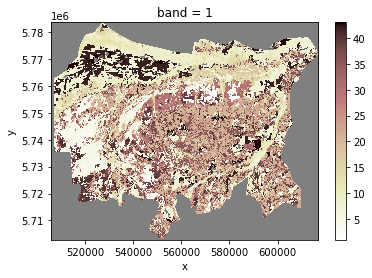

In [29]:
import copy
import rioxarray
import matplotlib.pyplot as plt
import xarray as xr

xr_da = xr.open_rasterio(
    "/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/chernobyl_habitat_data/polesia_hab_10res.tif"
)
cm = copy.copy(plt.get_cmap("pink_r"))
cm.set_bad("gray")
xr_da.where(xr_da != 0).isel(band=0).plot.imshow(cmap=cm)
plt.savefig("polesia.png")

In [11]:
cat /gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/chernobyl_habitat_data/README

Data created from 7z file provided by WCMC. Spurious files were deleted.


In [5]:
import xarray as xr
xr.open_dataset("/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/esa_cci_zonal_analysis/esa_cci_zonal_class_analysis_full_data.nc")

<xarray.Dataset>
Dimensions:                        (cci_landcover_class: 19, metric: 45, year: 24, zone: 4)
Coordinates:
  * metric                         (metric) object 'total_area' ... 'euclidea...
  * year                           (year) int16 1992 1993 1994 ... 2014 2015
  * cci_landcover_class            (cci_landcover_class) int32 10 11 ... 201 210
  * zone                           (zone) object 'E+60' ... 'Polesie Exclusio...
Data variables:
    __xarray_dataarray_variable__  (zone, cci_landcover_class, metric, year) float64 ...

In [2]:
da = return_da(ty_v="chern")
da

<xarray.DataArray (yr: 32, y: 7361, x: 11905, band: 3)>
[8412739680 values with dtype=float32]
Coordinates:
  * x        (x) float64 28.27 28.27 28.27 28.27 ... 31.47 31.47 31.47 31.47
  * y        (y) float64 52.48 52.48 52.48 52.48 52.48 ... 50.5 50.5 50.5 50.5
    year     (yr) int32 ...
  * band     (band) object 'red' 'green' 'blue'
Dimensions without coordinates: yr
Attributes:
    description:  Normalized reflectance at chern.

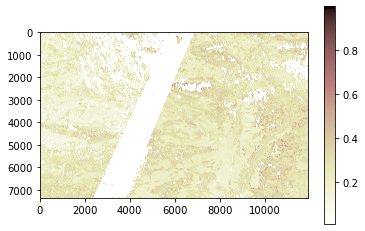

In [4]:
import matplotlib.pyplot as plt
plt.imshow(da.isel(yr=5, band=1), cmap='pink_r')
plt.colorbar()

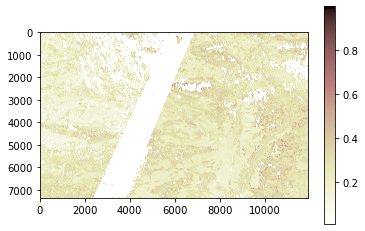

In [5]:
plt.imshow(da.isel(yr=5, band=1).values, cmap='pink_r')
plt.colorbar()

  0%|          | 0/3 [00:00<?, ?it/s]

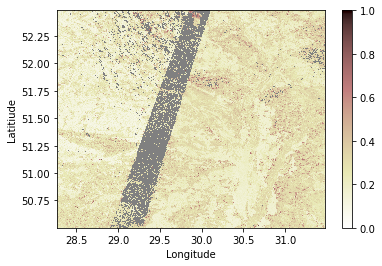

 33%|███▎      | 1/3 [00:03<00:06,  3.37s/it]

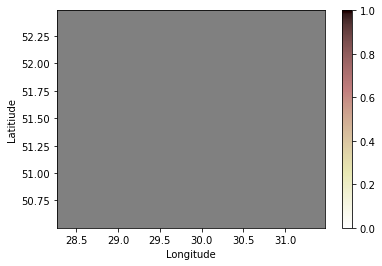

 67%|██████▋   | 2/3 [00:06<00:03,  3.22s/it]

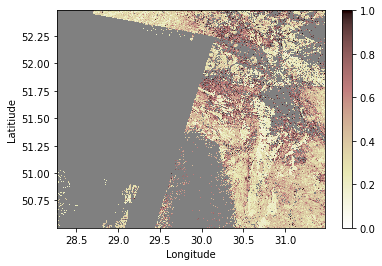

100%|██████████| 3/3 [00:09<00:00,  3.27s/it]


In [21]:
from tqdm import tqdm
import copy

for yr in tqdm([5, 10, 15]):
    cm = copy.copy(plt.get_cmap("pink_r"))
    cm.set_bad("gray")
    da.isel(yr=yr, band=1).plot.imshow(cmap=cm, vmin=0, vmax=1)
    plt.ylabel("Latitiude")
    plt.xlabel("Longitude")
    plt.title("")
    plt.show()

In [11]:
da.isel(yr=5, band=1).values[90:100, 90:100]

array([[0.15616667, 0.14516667, 0.14516667, 0.134     , 0.12266666,
        0.12266666, 0.10266667, 0.10266667, 0.10266667, 0.12266666],
       [0.14516667, 0.134     , 0.134     , 0.134     , 0.12266666,
        0.12266666, 0.12266666, 0.12266666, 0.10266667, 0.10266667],
       [0.144     , 0.14266667, 0.14266667, 0.12283333, 0.10266667,
        0.10266667, 0.10266667, 0.10266667, 0.10266667, 0.10266667],
       [0.143     , 0.151     , 0.151     , 0.151     , 0.12283333,
        0.12283333, 0.10266667, 0.10266667, 0.10266667, 0.121     ],
       [0.151     , 0.143     , 0.143     , 0.121     , 0.121     ,
        0.121     , 0.121     , 0.11183333, 0.11183333, 0.12183333],
       [0.169     , 0.121     , 0.121     , 0.10266667, 0.121     ,
        0.121     , 0.121     , 0.11266667, 0.11266667, 0.12283333],
       [0.205     , 0.143     , 0.12266666, 0.12266666, 0.12266666,
        0.12266666, 0.12266666, 0.1005    , 0.1005    , 0.12283333],
       [0.24066667, 0.16533333, 0.121    

## Check NaN values

  0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-21-78b2c73b9b6c>:37: RuntimeWarning: All-NaN slice encountered
  array_min, array_max = np.nanmin(array), np.nanmax(array)
100%|██████████| 32/32 [07:00<00:00, 13.14s/it]


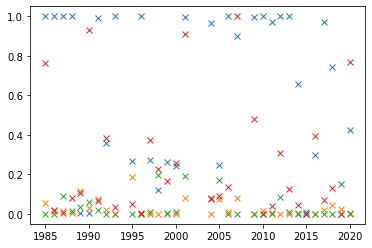

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

nan_perc = [[] for x in range(4)]

for i in tqdm(range(32)):
    for j in range(4):
        a = return_normalized_array(path_da.isel(yr=i, mn=j, ty=0).values.tolist())
        nan_perc[j].append(np.isnan(a).sum()/np.prod(a.shape))

for j in range(4):
    plt.plot(path_da.coords['yr'], nan_perc[j], 'x')

plt.show()

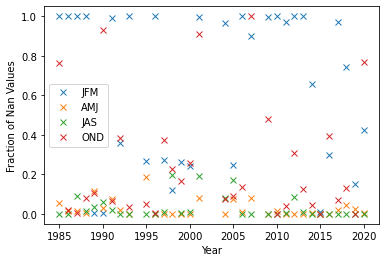

In [33]:
labels = path_da.coords['mn'].values.tolist()
for j in range(4):
    plt.plot(path_da.coords['yr'], nan_perc[j], 'x', label=labels[j])

plt.legend()
plt.ylabel('Fraction of Nan Values')
plt.xlabel('Year')
plt.show()

In [30]:
path_da.coords['mn'].values.tolist()

['JFM', 'AMJ', 'JAS', 'OND']

## Old Xarray to Video Function

In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import imageio
import matplotlib.pyplot as plt
from tqdm import tqdm

"""
Example use:

    da = xr.open_dataarray(...)

    video_path = ...

    land_mask = np.load(...)

    xarray_to_video(
        da, video_path, mask=land_mask, mask_type='contour',
        fps=10, cmap='inferno', figsize=10
    )

"""


def gen_frame_func(da, mask=None, mask_type="contour", cmap="viridis", figsize=15):
    """
    Create imageio frame function for xarray.DataArray visualisation.

    Parameters:
    da (xr.DataArray): Dataset to create video of.

    mask (np.ndarray): Boolean mask with True over masked elements to overlay
    as a contour or filled contour. Defaults to None (no mask plotting).

    mask_type (str): 'contour' or 'contourf' dictating whether the mask is overlaid
    as a contour line or a filled contour.

    """

    max = da.max().values
    min = da.min().values

    def make_frame(date):
        fig, ax = plt.subplots(figsize=(figsize, figsize))
        ax.imshow(da.sel(time=date), cmap=cmap, clim=(min, max))
        if mask is not None:
            if mask_type == "contour":
                ax.contour(mask, levels=[0.5, 1], colors="k")
            elif mask_type == "contourf":
                ax.contourf(mask, levels=[0.5, 1], colors="k")
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)

        ax.set_title(
            "{:04d}/{:02d}/{:02d}".format(date.year, date.month, date.day),
            fontsize=figsize * 4,
        )

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        plt.close()
        return image

    return make_frame


def xarray_to_video(
    da,
    video_path,
    fps,
    mask=None,
    mask_type="contour",
    video_dates=None,
    cmap="viridis",
    figsize=15,
):

    """
    Generate video of an xarray.DataArray. Optionally input a list of
    `video_dates` to show, otherwise the full set of time coordiantes
    of the dataset is used.
    """

    if video_dates is None:
        video_dates = [pd.Timestamp(date).to_pydatetime() for date in da.time.values]

    make_frame = gen_frame_func(
        da=da, mask=mask, mask_type=mask_type, cmap=cmap, figsize=figsize
    )

    imageio.mimsave(
        video_path, [make_frame(date) for date in tqdm(video_dates)], fps=fps
    )

## New Xarray to Video

In [4]:
import copy
import numpy as np
import rioxarray
import xarray as xr
import pandas as pd
import imageio
import matplotlib.pyplot as plt
from tqdm import tqdm

"""
Example use:

    da = xr.open_dataarray(...)

    video_path = ...

    land_mask = np.load(...)

    xarray_to_video(
        da, video_path, mask=land_mask, mask_type='contour',
        fps=10, cmap='pink_r', figsize=10
    )

"""


def gen_frame_func(da, mask=None, mask_type="contour", cmap="pink_r", figsize=15):
    """
    Create imageio frame function for xarray.DataArray visualisation.

    Parameters:
    da (xr.DataArray): Dataset to create video of.

    mask (np.ndarray): Boolean mask with True over masked elements to overlay
    as a contour or filled contour. Defaults to None (no mask plotting).

    mask_type (str): 'contour' or 'contourf' dictating whether the mask is overlaid
    as a contour line or a filled contour.

    """
    cm = copy.copy(plt.get_cmap(cmap))
    cm.set_bad("gray")

    max = da.max().values
    min = da.min().values

    def make_frame(yr):
        fig, ax = plt.subplots(figsize=(10, 7))
        da.sel(yr=yr).plot.imshow(clim=(min, max))
        # ax.imshow(da.sel(yr=yr), cmap=cmap, clim=(min, max))
        if mask is not None:
            if mask_type == "contour":
                ax.contour(mask, levels=[0.5, 1], colors="k")
            elif mask_type == "contourf":
                ax.contourf(mask, levels=[0.5, 1], colors="k")
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        plt.close()
        return image

    return make_frame


def xarray_to_video(
    da,
    video_path,
    fps,
    mask=None,
    mask_type="contour",
    video_dates=None,
    cmap="viridis",
    figsize=15,
):
    """
    Generate video of an xarray.DataArray. Optionally input a list of
    `video_dates` to show, otherwise the full set of time coordiantes
    of the dataset is used.
    """
    if video_dates is None:
        video_dates = [yr for yr in da.yr.values]

    make_frame = gen_frame_func(
        da=da, mask=mask, mask_type=mask_type, cmap=cmap, figsize=figsize
    )

    imageio.mimsave(
        video_path,
        [make_frame(date) for date in tqdm(video_dates, desc=video_path)],
        fps=fps,
    )
    print("Video " + video_path + " made.")


for mn_v in [# "JFM", "AMJ", 
             "JAS", "OND"]:
    for ty_v in ["chern", "hab"]:
        da = return_da(ty_v=ty_v, mn_v=mn_v)
        xarray_to_video(
            da,
            ty_v + "_" + mn_v + ".mp4",
            mask_type="contour",
            fps=10,
            cmap="pink_r",
            figsize=10,
        )

chern_JAS.mp4: 100%|██████████| 32/32 [07:04<00:00, 13.27s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (720, 504) to (720, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video chern_JAS.mp4 made.


hab_JAS.mp4: 100%|██████████| 32/32 [02:45<00:00,  5.16s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (720, 504) to (720, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video hab_JAS.mp4 made.


chern_OND.mp4: 100%|██████████| 32/32 [07:27<00:00, 14.00s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (720, 504) to (720, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video chern_OND.mp4 made.


hab_OND.mp4: 100%|██████████| 32/32 [02:57<00:00,  5.54s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (720, 504) to (720, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video hab_OND.mp4 made.


## Rasterize Shape Files

## Xarray Testing

In [17]:
import xarray as xr
xr_da = xr.open_rasterio("/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/gee_satellite_data/2012/L7_chern_2012_AMJ.tif")

In [36]:
xr_da = xr.open_rasterio(path_da.isel(yr=31, mn=2, ty=0).values.tolist())
xr_da

<xarray.DataArray (band: 4, y: 3313, x: 6360)>
[84282720 values with dtype=float64]
Coordinates:
  * band     (band) int64 1 2 3 4
  * y        (y) float64 52.46 52.46 52.46 52.46 ... 51.57 51.57 51.57 51.57
  * x        (x) float64 26.89 26.89 26.89 26.89 26.89 ... 28.6 28.6 28.6 28.6
Attributes:
    transform:      (0.00026949458523585647, 0.0, 26.88693577981093, 0.0, -0....
    crs:            +init=epsg:4326
    res:            (0.00026949458523585647, 0.00026949458523585647)
    is_tiled:       1
    nodatavals:     (nan, nan, nan, nan)
    scales:         (1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0)
    descriptions:   ('B1', 'B4', 'B3', 'B2')
    AREA_OR_POINT:  Area

In [38]:
xr_da.values.shape

(4, 3313, 6360)

In [46]:
xr_da.coords['y'].values.shape

(3313,)

In [45]:
xr_da.coords['x'].values.shape

(6360,)

In [12]:
xr.open_rasterio(path_da.isel(yr=15, mn=2, ty=0).values.tolist())

<xarray.DataArray (band: 3, y: 3313, x: 6360)>
[63212040 values with dtype=float64]
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 52.46 52.46 52.46 52.46 ... 51.57 51.57 51.57 51.57
  * x        (x) float64 26.89 26.89 26.89 26.89 26.89 ... 28.6 28.6 28.6 28.6
Attributes:
    transform:      (0.00026949458523585647, 0.0, 26.88693577981093, 0.0, -0....
    crs:            +init=epsg:4326
    res:            (0.00026949458523585647, 0.00026949458523585647)
    is_tiled:       1
    nodatavals:     (nan, nan, nan)
    scales:         (1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0)
    descriptions:   ('B3', 'B2', 'B1')
    AREA_OR_POINT:  Area

In [14]:
xr.open_rasterio(path_da.isel(yr=1, mn=2, ty=0).values.tolist())

<xarray.DataArray (band: 3, y: 3313, x: 6360)>
[63212040 values with dtype=float64]
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 52.46 52.46 52.46 52.46 ... 51.57 51.57 51.57 51.57
  * x        (x) float64 26.89 26.89 26.89 26.89 26.89 ... 28.6 28.6 28.6 28.6
Attributes:
    transform:      (0.00026949458523585647, 0.0, 26.88693577981093, 0.0, -0....
    crs:            +init=epsg:4326
    res:            (0.00026949458523585647, 0.00026949458523585647)
    is_tiled:       1
    nodatavals:     (nan, nan, nan)
    scales:         (1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0)
    descriptions:   ('B3', 'B2', 'B1')
    AREA_OR_POINT:  Area

In [15]:
path_da.isel(yr=31, mn=2, ty=0).values.tolist()


'/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/gee_satellite_data/2020/L8_hab_2020_JAS.tif'

In [2]:
import stats

ModuleNotFoundError: No module named 'stats'